# Different delay widths

In this notebook we want to analyse the effect of different priors for the delay width.

In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

# Save figure  keyword args   
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
fig_path = "./figures"

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)


In [7]:
countries = [
    'England',
    "Czechia",
    "Italy",
    'Scotland',
    "Spain",
    "Germany",
    "France"
]
tune = 500
draws = 1000
max_treedepth = 12
traces, models, dls = {}, {}, {}
for country in countries:
    models_t, traces_t, dls_t = [],[],[]
    for median_width in [0.5, 1.0, 2.0]:
        fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data=0"+
            f"-draw_delay=True"+
            f"-weighted_alpha_prior=0"+
            f"-prior_delay=-1"+
            f"-width_delay_prior=0.1"+
            f"-sigma_incubation=-1.0"+
            f"-median_width_delay={median_width}"+
            f"-interval_cps={10.0}"+
            f"-tune={tune}"+
            f"-draws={draws}"+
            f"-max_treedepth={max_treedepth}.pickled")
        model, trace = load(fstr)
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
        models_t.append(model)
        traces_t.append(trace)
        dls_t.append(dl)
    models[country] = models_t
    traces[country] = traces_t
    dls[country] = dls_t

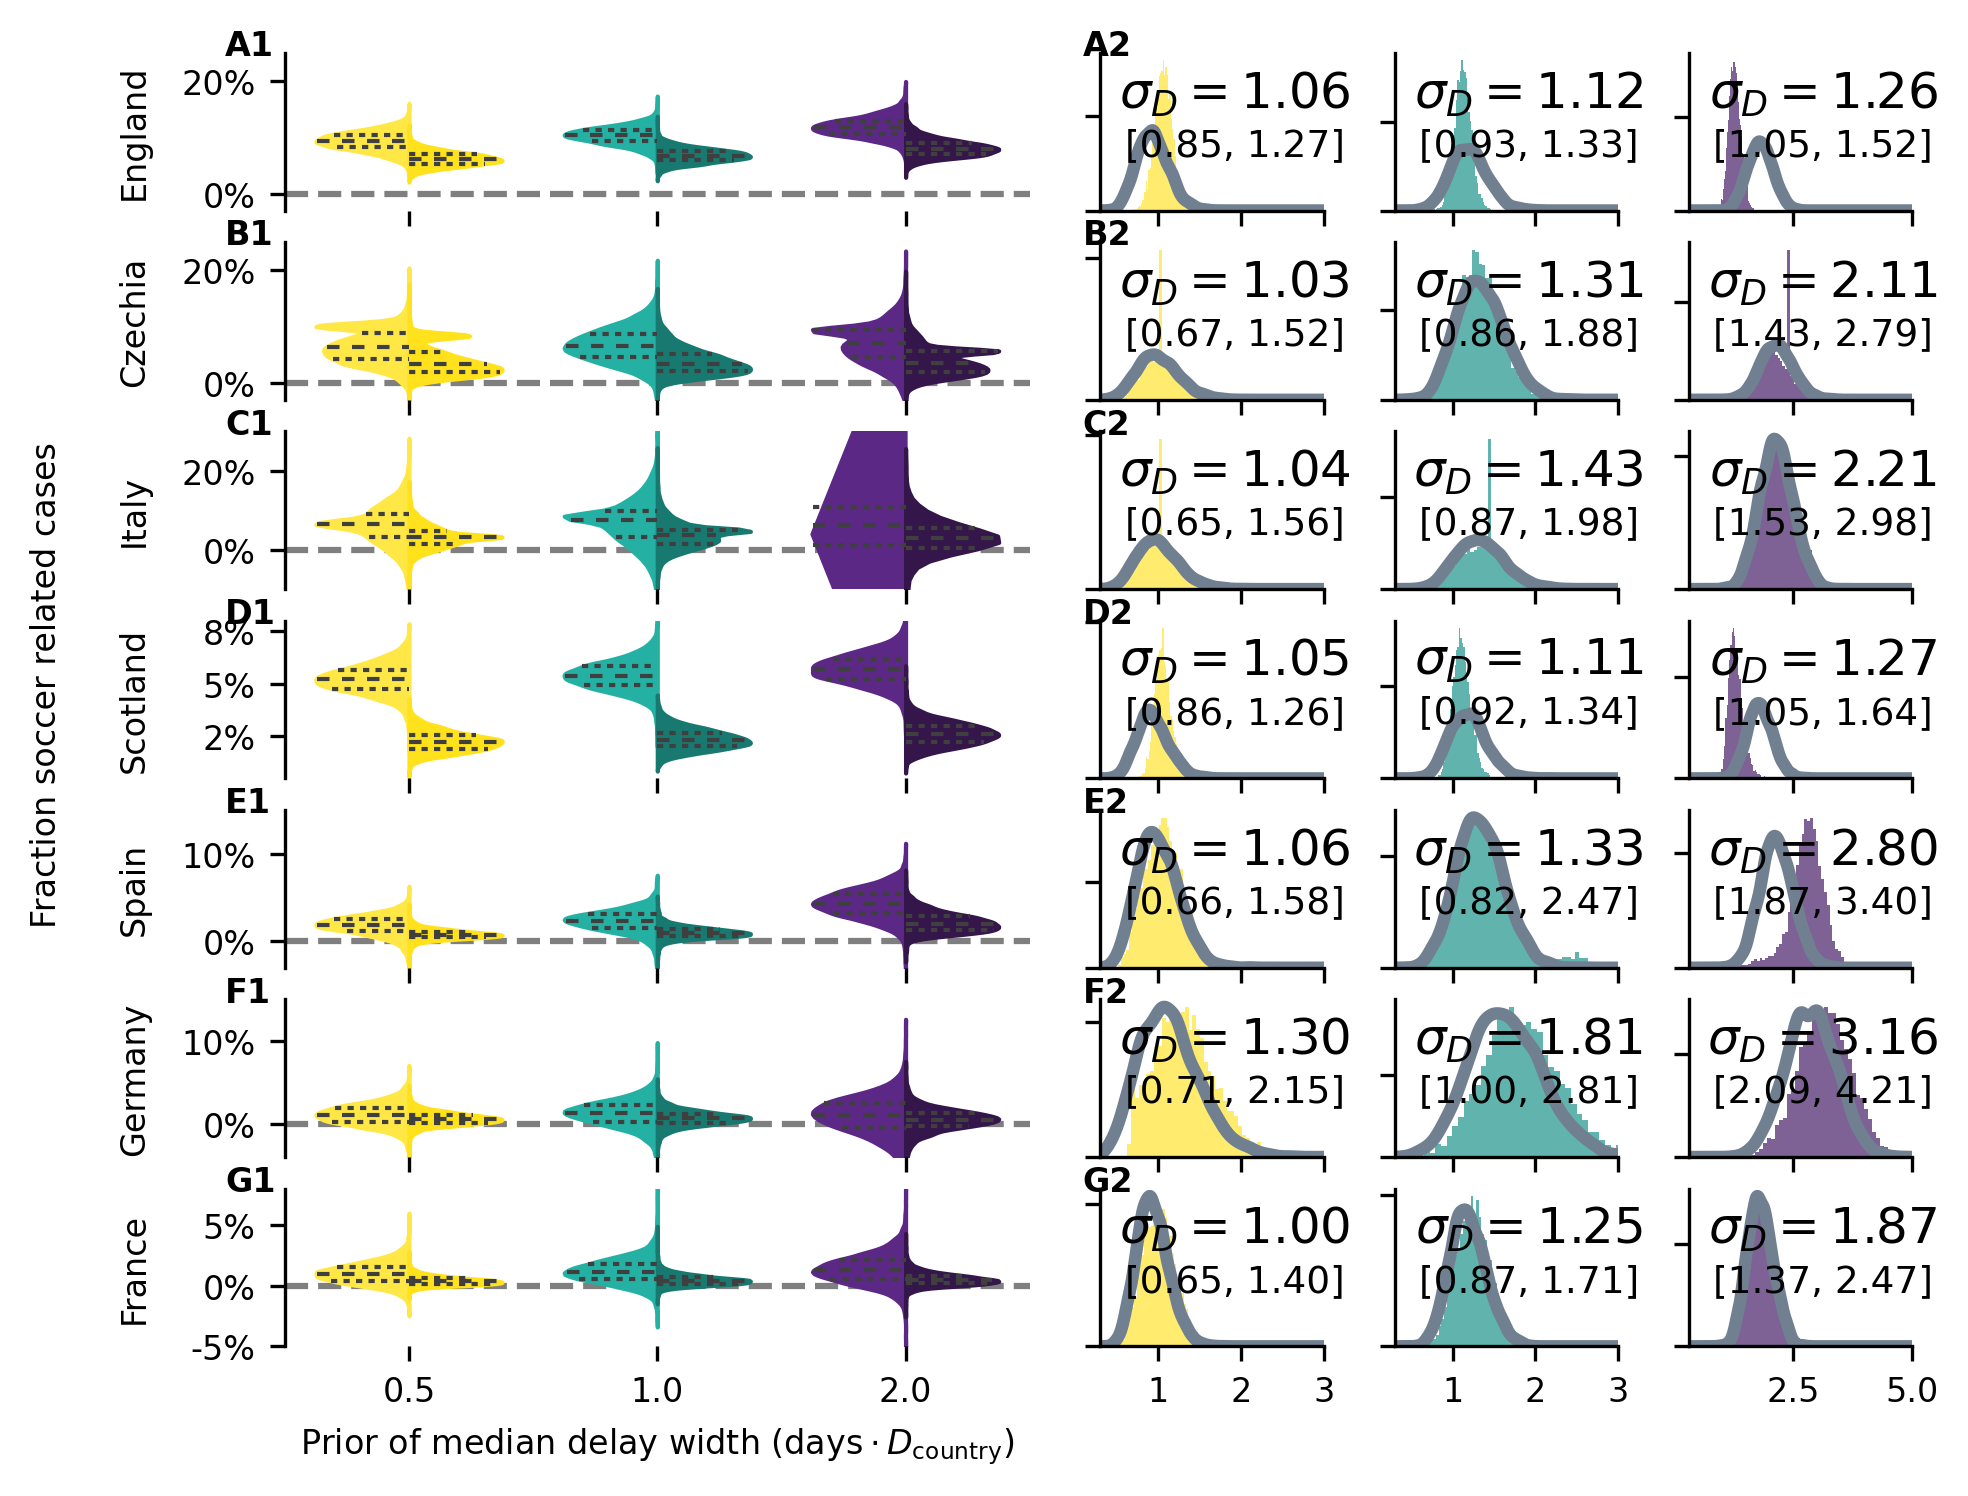

In [33]:
from covid19_soccer.plot.utils import lighten_color
from covid19_soccer.plot.rcParams import *
from matplotlib.colors import to_hex
fig, axes = plt.subplots(len(countries),4,figsize=(7,len(countries)*0.8),gridspec_kw={"width_ratios":[1,0.3,0.3,0.3]})

colors_base = ["#ffe530","#1e958a","#481f68"]
l = 0.9
d = 1.1

colors_mf = []
for col in colors_base:
    colors_mf.append(to_hex(lighten_color(col,l)))
    colors_mf.append(to_hex(lighten_color(col,d)))
colors_mf = np.array(colors_mf)

for i, country in enumerate(countries):
    covid19_soccer.plot.other.soccer_related_cases_overview(
        ax=axes[i,0],
        traces=traces[country],
        models=models[country],
        dls=dls[country],
        country_order=[0,1,2],
        colors=colors_mf
        )
    axes[i,0].set_xticklabels(["0.5","1.0","2.0"])
    axes[i,0].set_ylabel(dls[country][0].countries[0])
    axes[i,0].yaxis.set_label_coords(-0.18, 0.5)

    if i != len(countries)-1:
        axes[i,0].set_xticklabels([])

    for j, (trace, model , dl, color,ls) in enumerate(zip(traces[country], models[country], dls[country], colors_base, [(0, (5, 7)),"dashed","-"])):
        
        if j == 2:
            axes[i,j+1].set_xlim(0.3,5)
        else:
            axes[i,j+1].set_xlim(0.3,3)
        rcParams.color_posterior=colors_base[j]
        covid19_soccer.plot.distributions.distribution(
            model,
            trace,
            "delay-width",
            nSamples_prior=5000,
            title="",
            dist_math="\sigma_{D}",
            ax=axes[i,j+1],
        )
        if i != len(countries)-1:
            axes[i,j+1].set_xticklabels([])
    #axes[i,1].set_ylim(0.6,2)
    #axes[i,1].set_yticks([1,1.5])
    #axes[i,1].yaxis.set_label_coords(-0.12, 0.5)
# Array of capital letters
letters = np.array(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))

# Add label letters to figure
for i, country in enumerate(countries):
    axes[i,0].text(
        -0.08,
        1.15,
        letters[i]+"1",
        transform=axes[i,0].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top"
    )
    axes[i,1].text(
        -0.08,
        1.15,
        letters[i]+"2",
        transform=axes[i,1].transAxes,
        fontsize=8,
        fontweight="bold",
        verticalalignment="top"
    )
# set ylims
ylims = {
    "England":[-3,25],
    "Czechia":[-3,25],
    "Italy":[-10,30],
    "Scotland":[0.5,8],
    "Spain":[-3,15],
    "Germany":[-4,15],
    "France":[-5,8],
}
for i, country in enumerate(countries):
    axes[i,0].set_ylim(ylims[country])

# Set overarching y label
axes[0,0].text(-0.32,-len(countries)/2+0.5,"Fraction soccer related cases",transform=axes[0,0].transAxes,rotation=90,ha="center",va="center",fontsize=8)

axes[-1,0].set_xlabel("Prior of median delay width ($\mathrm{days}\cdot D_\mathrm{country}}/5$)")
plt.show()
plt.close(fig=fig)
